![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=BQML+Multivariate+Forecasting+with+ARIMA%2B+XREG.ipynb)

ToDo List:
- [ ] Add comparison of result to Univariate
- [ ] Add univariate as pre-req then parse results to select series for multivariate
- [ ] Keep ToDo list as features come out: multiple time-series, explanations, detect_anomalies

# BQML Multivariate Forecasting with ARIMA+ including external regressors

In this notebook we will fit a forecasting model to the data reviewed and prepared in the [previous notebook](./1%20-%20BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb) - citibike bike rentals daily volume by station near Central Park in New York City.  

For this attempt we will keep the forecasting activity within the data warehouse by using BigQuery's built-in machine learning - often called BQML.  

**MULTIVARIATE Forecasting with ARIMA+ including Linear External Regressors**

One of the model type available is ARIMA+ with XREG (`model_type = 'ARIMA_PLUS_XREG'`).  This  fits multivariate forecasts by using time variying covariates as linear external regressors.  This is an extention of ARIMA+ univariate forecasting where the inclusing of additional information can improve the forecast accuracy.  The weights from a linear regression of the covariates is aggregated with the ARIMA forecasts.

**UNIVARIATE Forecasting with ARIMA+**

Univariate forecasting with ARIMA+ is available directly (`model_type = 'ARIMA_PLUS'`).  This fits univariate forecasts by using auto-regressive integrated moving average (ARIMA) models while also automatically handling many of the data pre and post processing steps required.  The forecast can be evaluated with various provided metrics and even using SQL to calculate customized metrics.  It is also possible to identify anomalies using BigQuery ML with the function `ML.DETECT_ANOMALIES`.  This model type is fit in the notebook [2 - BQML Univariate Forecasting with ARIMA+](./2%20-%20BQML%20Univariate%20Forecasting%20with%20ARIMA+.ipynb).

**ARIMA+**

ARIMA is a statistical model of time series data that helps understand patterns and forecast future points in time.  The model is made up of three parts:
- AR, or autoregressive.  Indicates a variable is regressed against it own previous values.
    - `p`, the parameter that indicates the number of lags, or previous time points considered
- I, or integrated.  Indicates the values have been replaced with the difference between a value and the previous value.
    - `d`, the parameter that indicates the degree of differencing or number of times the data have had past value subtracted 
- MA, or moving avarge.  Indicates the regression error is a combination of value at various time in the past.
    - `q`, the parameter that indicates the order of the moving-average

Reference:
- [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

**ARIMA+ XREF**

This can be thought of a ARIMAX.  The additional letter stands for external regressors.  As an extention of ARIMA is still has the `p`, `d` and `q` parameters and adds a parameter `b`:
- X, or external regressors.  Indicates time varying regressors are included.
    - `b`, the parameter for the number of weights from a linear regression of the external regressors

**BigQuery ML (BQML)**

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Prerequisites:**
- [BigQuery Time Series Forecasting Data Review and Preparation](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - prepare data for this notebook

**Resources:**
- [Bigquery ML End-to-end user journey for each model](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [How to do time series forecasting in BigQuery](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)
- [How to do multivariate time series forecasting in BigQuery ML](https://cloud.google.com/blog/products/data-analytics/how-to-do-multivariate-time-series-forecasting-in-bigquery-ml)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Codelab: Time Series Forecasting with Vertex AI and BigQuery ML](https://codelabs.developers.google.com/codelabs/time-series-forecasting-with-cloud-ai-platform#0)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore2_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore2_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-bqml-multivariate'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-1'

viz_limit = 12

packages:

In [3]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Review Time Series

In [5]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

Retrieve Key Dates for splits:

In [6]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Retrieve raw data:

In [7]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### Plot Time Series - Overlay Covariates

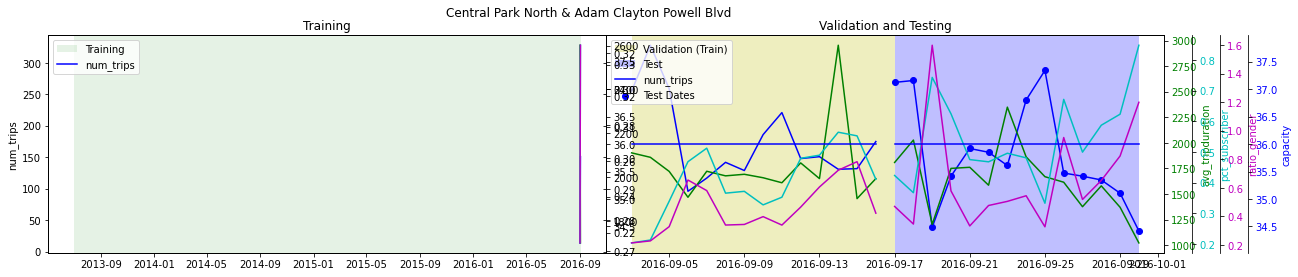

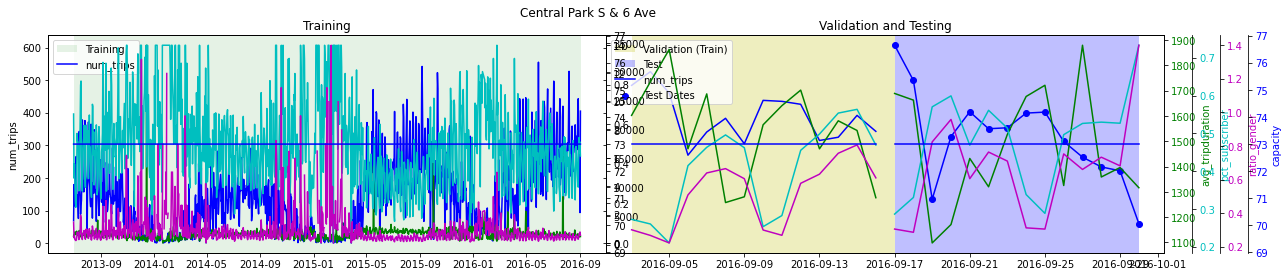

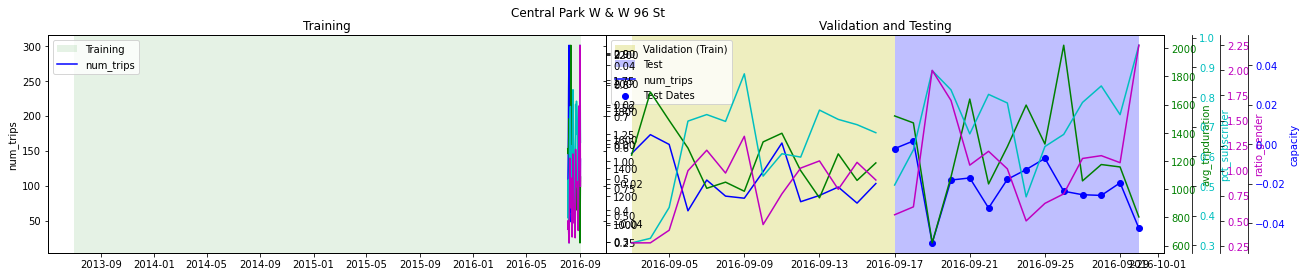

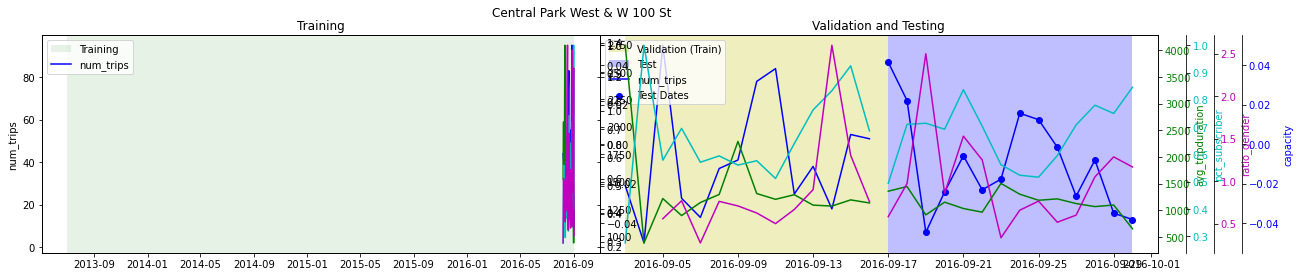

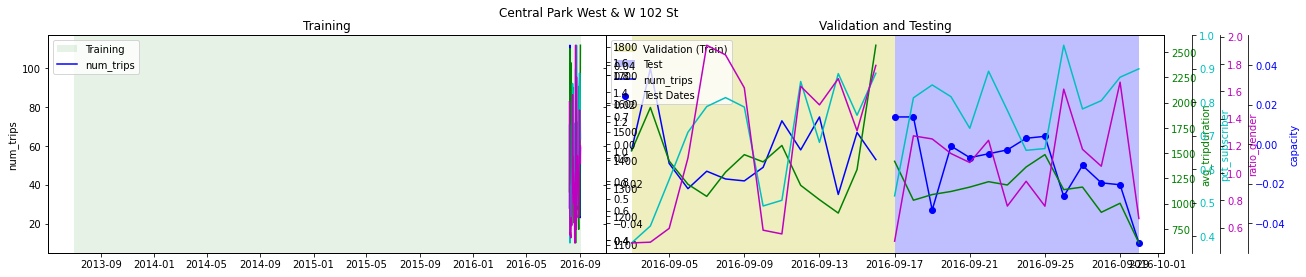

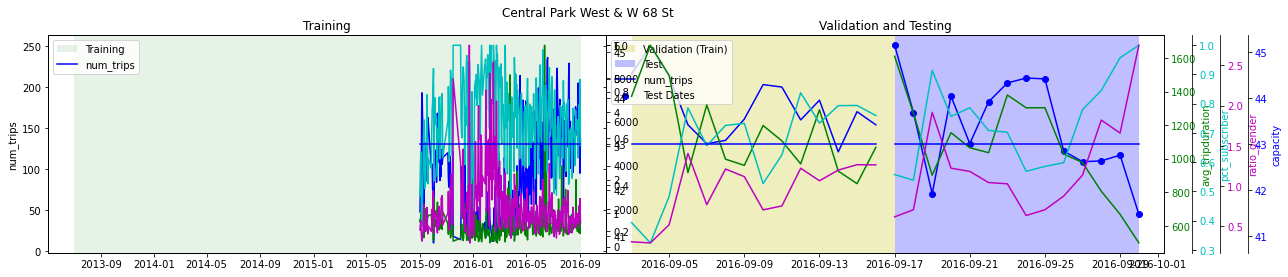

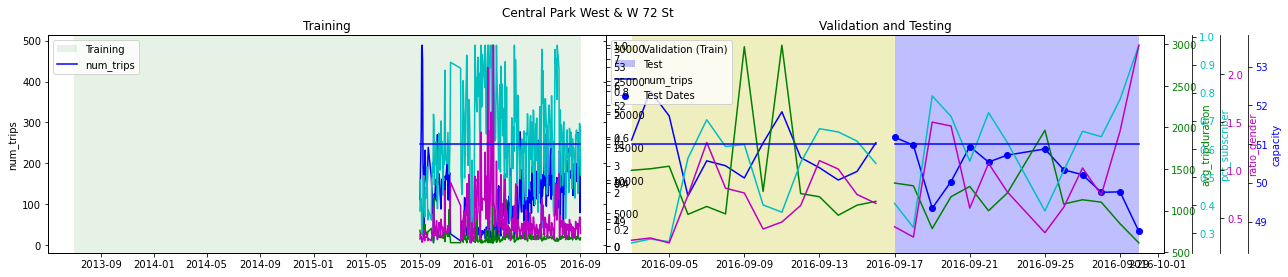

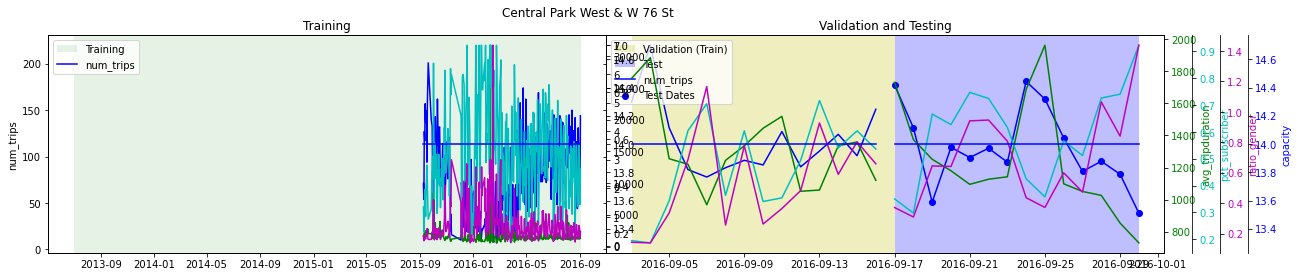

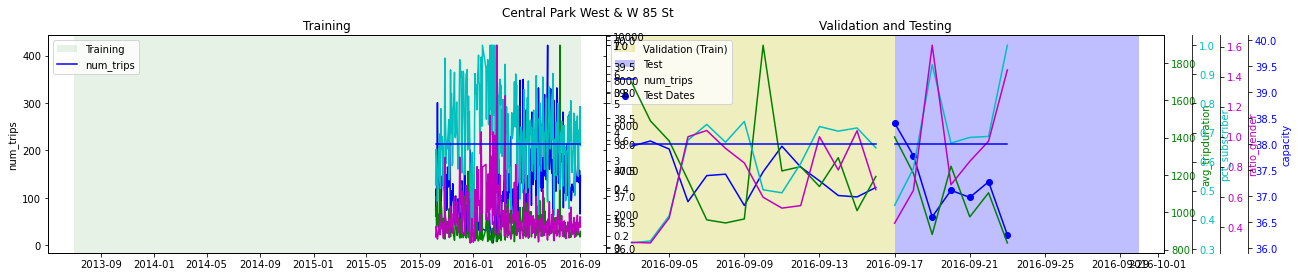

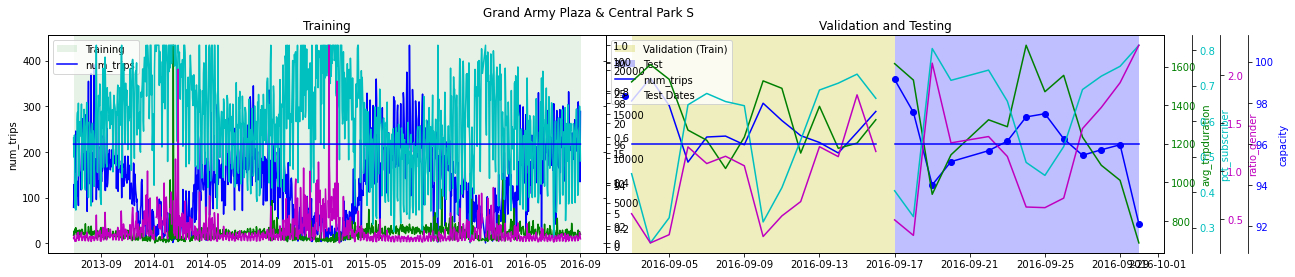

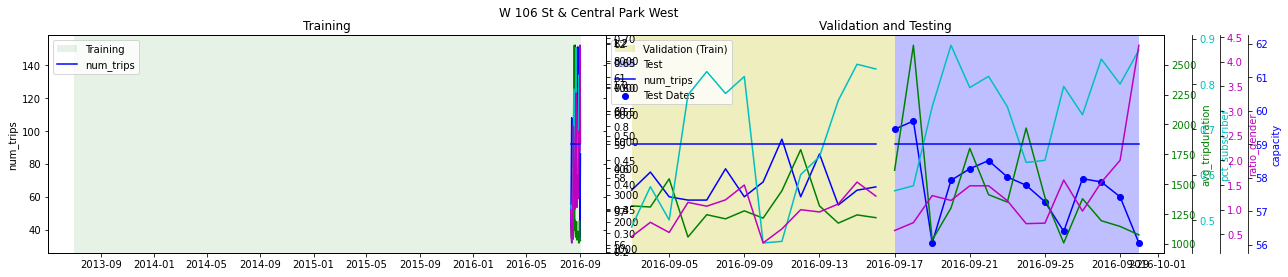

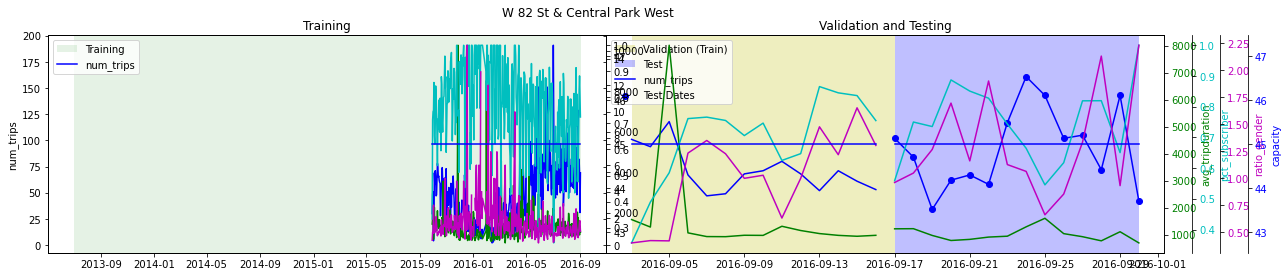

In [10]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')
        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # overaly covariates (up to 5):
        for c, cov in enumerate(COVARIATE_COLUMNS):
            colors = ['g','c','m','b','r']
            if c<5:
                
                twin = axes[0].twinx()
                twin.plot(traindf[TIME_COLUMN], traindf[cov], color = colors[c], label = f'{cov}')
                
                twin = axes[1].twinx()
                twin.set_ylabel(cov, color = colors[c])
                twin.tick_params(axis = 'y', labelcolor = colors[c])
                twin.spines.right.set_position(("axes", 1+.05*c))
                twin.plot(valdf[TIME_COLUMN], valdf[cov], color = colors[c], label = f'{cov}')
                twin.plot(testdf[TIME_COLUMN], testdf[cov], color = colors[c], label = f'{cov}')
        
        # display result
        plt.show()

---
## Create Forecast Model
Use BigQuery ML Arima+ (`model_type = 'ARIMA_PLUS_XREG'`), a feature of [BigQuery ML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).  This does univariate time series modeling using ARIMA while also automating many of the task of this type of inference: preprocessing, holiday adjustments, spikes, dips, outlier, seasonal & trend decomposition, step change adjustment, trend modeling, forecasting.  A representation of this pipeline from the BigQuery ML documentation:

<p><center>
    <img alt="ARIMA_PLUS_XREG Flowchart" src="https://cloud.google.com/static/bigquery-ml/images/BQ_ARIMA_PLUS_XREG_diagram.png" width="75%">
</center><p>

A deeper look at the ARIMA+ process:   
    
<p><center>
    <img alt="ARIMA_PLUS Flowchart" src="https://cloud.google.com/bigquery-ml/images/BQ_ARIMA_diagram.png" width="75%">
</center><p>

**NOTE** At this point in time (March 2023) the `ARIMA_PLUS_XREG` is in [preview](https://cloud.google.com/products#product-launch-stages) and does not have the `time_series_id_col` parameter to fit multiple forecast.  Instead, the `WHERE` statement here selects the data for a single station for example.

In [11]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
#forecast_val_length = 14

In [14]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       auto_arima_max_order = 5,
       holiday_region = 'US',
       horizon = {forecast_horizon}+{forecast_test_length}
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
        AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
"""
print(query)


    CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_forecasting.forecasting-1_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = 'starttime',
       time_series_data_col = 'num_trips',
       auto_arima_max_order = 5,
       holiday_region = 'US',
       horizon = 14+14
      ) AS
    SELECT starttime, num_trips,
        avg_tripduration, pct_subscriber, ratio_gender, capacity
    FROM `statmike-mlops-349915.applied_forecasting.forecasting-1_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
        AND start_station_name = 'Central Park S & 6 Ave'



In [19]:
job = bq.query(query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 25.445


### Review The ARIMA Coefficients
Reference for [`ML.ARIMA_COEFFICIENTS`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients)

In [21]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
coefficients = bq.query(query).to_dataframe()
coefficients

,ar_coefficients,ma_coefficients,intercept_or_drift,processed_input,weight,category_weights
0,[],[],NaN,avg_tripduration,-1.513919e-03,[]
1,[],[],NaN,pct_subscriber,-3.021674e+02,[]
2,[],[],NaN,ratio_gender,2.385852e+00,[]
3,[],[],NaN,capacity,1.663402e+00,[]
4,[],[],NaN,__INTERCEPT__,3.435246e-11,[]
5,[],"[-0.8285040942776327, -0.2127547999529793, 0.6...",0.0,None,NaN,[]


### Review the input features
Reference for [`ML.FEATURE_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature)

In [22]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,num_trips,1.000,555.000000,144.153912,130.000000,112.409702,NaN,0,NaN
1,starttime,NaN,NaN,NaN,NaN,NaN,1163.0,0,NaN
2,avg_tripduration,336.625,34597.615385,1918.560216,1829.693878,1334.905339,NaN,0,NaN
3,pct_subscriber,0.000,1.000000,0.497785,0.466667,0.214707,NaN,0,NaN
4,ratio_gender,0.000,14.000000,0.908012,0.555556,1.329083,NaN,26,NaN


### Review the Training Information
Reference for [`ML.TRAINING_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train#:~:text=For%20time%20series%20models)

In [23]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

,training_run,iteration,duration_ms
0,0,0,12099


---
## Forecast Evaluation

### Forecast Metrics
Reference for [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#:~:text=ml.principal_component_info%20function.-,The%20ML.EVALUATE%20function%20returns,-the%20following%20columns) for `model_type = 'ARIMA_PLUS_XREG'`

The metrics returned depend on if input (test) data is provided and if `perform_aggregation` is `True` or `False`.  If `False` then metrics per timestamp are provide, and if `True` then metrics per `time_series_id_col` are provided.

In [29]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST'
                AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
        ),
        STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics

,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,84.689506,12568.568569,112.109627,37.609473,31.090429


### Evaluate Time Series Models
Reference for [`ML.ARIMA_EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-evaluate)

A model metrics table:
ARIMA terms:
- p = how many autoregressive terms
- d =  how many nonseasonal differences needed for stationarity
- q = number of lagged forecast errors (moving average part)


In [30]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT(FALSE as show_all_candidate_models))
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,0,1,5,False,-5857.894211,11727.788421,1266.716809,"[WEEKLY, YEARLY]",True,True,False,


---
## Forecast Time Series
Reference for [`ML.FORECAST`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-forecast)

Calculates the forecasted value per timestamp and provides standard error and prediction intervals at the requested confidence level.

The default `horizon` is 3 so this parameter may need to be set to the size used at training.

**NOTE** When using external regressors their values are need for forecast to be computed.

In [37]:
query = f"""
    SELECT *
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST'
                AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
        )
        )
"""
forecast = bq.query(query).to_dataframe()
forecast

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2016-09-17 00:00:00+00:00,373.586444,35.590965,0.95,303.954212,443.218676
1,2016-09-18 00:00:00+00:00,461.201371,36.110553,0.95,390.552588,531.850154
2,2016-09-19 00:00:00+00:00,336.684709,36.140398,0.95,265.977535,407.391883
3,2016-09-20 00:00:00+00:00,238.410863,41.585964,0.95,157.049667,319.772058
4,2016-09-21 00:00:00+00:00,227.453173,48.100268,0.95,133.347015,321.559331
5,2016-09-22 00:00:00+00:00,208.416623,48.156597,0.95,114.200259,302.632988
6,2016-09-23 00:00:00+00:00,271.401496,48.212861,0.95,177.075054,365.727938
7,2016-09-24 00:00:00+00:00,379.234904,48.269059,0.95,284.798512,473.671295
8,2016-09-25 00:00:00+00:00,366.943849,48.325192,0.95,272.397637,461.490062
9,2016-09-26 00:00:00+00:00,257.832584,48.381260,0.95,163.176677,352.488490


## Forecast + Explanations for Time Series
Reference for [`ML.EXPLAIN_FORECAST`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-forecast)

**NOTE** At this point in time (March 2023) the `ARIMA_PLUS_XREG` is in [preview](https://cloud.google.com/products#product-launch-stages) and does not yet use the `ML.EXPLAIN_FORECAST` function. In preparation for it the results of the forecast table above are used and remapped to the expected column names.

In [47]:
query = f"""
    SELECT *,
        'Central Park S & 6 Ave' AS {SERIES_COLUMN},
        EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
        forecast_value AS time_series_adjusted_data
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE {SERIES_COLUMN} = 'Central Park S & 6 Ave'
        )
        )
    ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()
explain

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,start_station_name,starttime,time_series_adjusted_data
0,2016-09-17 00:00:00+00:00,373.586444,35.590965,0.95,303.954212,443.218676,Central Park S & 6 Ave,2016-09-17,373.586444
1,2016-09-18 00:00:00+00:00,461.201371,36.110553,0.95,390.552588,531.850154,Central Park S & 6 Ave,2016-09-18,461.201371
2,2016-09-19 00:00:00+00:00,336.684709,36.140398,0.95,265.977535,407.391883,Central Park S & 6 Ave,2016-09-19,336.684709
3,2016-09-20 00:00:00+00:00,238.410863,41.585964,0.95,157.049667,319.772058,Central Park S & 6 Ave,2016-09-20,238.410863
4,2016-09-21 00:00:00+00:00,227.453173,48.100268,0.95,133.347015,321.559331,Central Park S & 6 Ave,2016-09-21,227.453173
5,2016-09-22 00:00:00+00:00,208.416623,48.156597,0.95,114.200259,302.632988,Central Park S & 6 Ave,2016-09-22,208.416623
6,2016-09-23 00:00:00+00:00,271.401496,48.212861,0.95,177.075054,365.727938,Central Park S & 6 Ave,2016-09-23,271.401496
7,2016-09-24 00:00:00+00:00,379.234904,48.269059,0.95,284.798512,473.671295,Central Park S & 6 Ave,2016-09-24,379.234904
8,2016-09-25 00:00:00+00:00,366.943849,48.325192,0.95,272.397637,461.490062,Central Park S & 6 Ave,2016-09-25,366.943849
9,2016-09-26 00:00:00+00:00,257.832584,48.381260,0.95,163.176677,352.488490,Central Park S & 6 Ave,2016-09-26,257.832584


### Visualize Time Series with Forecast

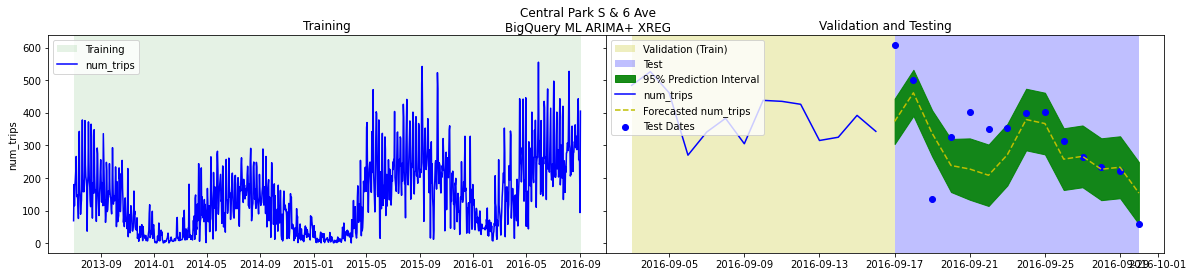

In [48]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
series = ['Central Park S & 6 Ave']
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        #fit_traindf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] < keyDates['val_start'][0])]
        #fit_valdf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] >= keyDates['val_start'][0]) & (explain[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        #axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        #axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['time_series_adjusted_data'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nBigQuery ML ARIMA+ XREG")

        # display result
        plt.show()

## Using SQL to Calculate Metrics

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity calculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [51]:
query = f"""
    WITH    
        FORECAST AS (
            SELECT
                'Central Park S & 6 Ave' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST' AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)

,start_station_name,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,Central Park S & 6 Ave,forecast,0.376095,84.689506,0.259499,12568.568569,112.109627,0.343518


Overall Metrics:

In [52]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                'Central Park S & 6 Ave' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,forecast,0.376095,84.689506,0.259499,12568.568569,112.109627,0.343518


---
## Anomaly Detection
Reference for [`ML.DETECT_ANOMALIES`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies)

**NOTE** At this point in time (March 2023) the `ARIMA_PLUS_XREG` is in [preview](https://cloud.google.com/products#product-launch-stages) and does not yet use the `ML.DETECT_ANOMALIES` function. This section will be completed once the feature is released.

---
## Remove Resources
see notebook "99 - Cleanup"